In [10]:
# Dataset

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

#
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import make_moons as moon
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# define the classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_recall_fscore_support

In [11]:
# set the dataset.
dataset = moon(5000, noise=0.3, random_state=42)
X,y = dataset

# split the training(labeled) as 10% of dataset
X_l, X_ul, y_l, y_ul = train_test_split(X, y, test_size=0.8, random_state=0)


# split the training(labeled) as 50% of  labeled dataset
X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X_l, y_l, test_size=0.5, random_state=0)

# 2-classifier
clf_1 = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=11))
        ]
)

# clf 1
clf_2 = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("RF", RandomForestClassifier())
        ]
)

clfs = [clf_1,clf_2]

In [12]:
# define ENV

# for clustering the unlabeld data

class Env():
    def __init__(self, classifiers, input_ul_data, k, X_test, y_test, X_reset, y_reset):
        # super().__init__

        self.models = classifiers
        # UN LABEL DATA
        self.X_ul = input_ul_data
        # define the evaluate data, later use for the reward
        self.X_eval = X_test
        self.y_eval = y_test
        self.X_reset = X_reset
        self.y_reset = y_reset
        # cluster the data
        self.action_size = k * 2  # because always cotraining has 2 classifiers, so action size is (K * 2) shape
        ############
        ##### deeply doubt above setings
        #############
        self.kmeans = KMeans(n_clusters=k,  n_init=10)
        self.cluster_label = self.kmeans.fit_predict(self.X_ul)
        self.u_cluster_label = np.unique(self.cluster_label)
        self.centroids = self.kmeans.cluster_centers_
        self.observation_size = self.get_state(reset=True).shape[1]
        self.prev_macro_f1 = 0.0

    ##############################
    # ###### FIX ###########
    ###############################
    # update 2 clf
    def train_2_clf(self, X, y):
        for clf in self.models:
            clf.fit(X, y)

    def get_state(self,reset=False):

        if reset:
            self.train_2_clf(self.X_reset, self.y_reset)
            # print("reset")

        #########################

        ########fix#################
        # only keep the most confidence of each classifier as the state views
        '''
        # The state vector does not need to contain the complete
        # class probability distribution for each cluster and classifier
        # since the classifier’s largest confidence is enough to help the agents decision.”
        '''
        #########################
        out_1 = self.models[0].predict_proba(self.centroids).max(axis=1)
        out_2 = self.models[1].predict_proba(self.centroids).max(axis=1)
        # state_proba = np.concatenate((out_1, out_2), axis=0)
        ##############################
        #### UPDATED 5-OCT-2024
        ## When choosen the action neeed calculation: cluster( '//2'), classifer ('%2')
        ###########
        state_proba = [[out_1[i],out_2[i]] for i in range(len(out_1))]
        return  torch.from_numpy(np.array(state_proba).flatten()).to(torch.float32).reshape(1, -1)


    def get_f1(self):
        classifier_weights = [clf.score(self.X_eval, self.y_eval) for clf in self.models]  # Weights based on validation accuracy
        combined_probabilities = np.average(
            [clf.predict_proba(self.X_eval) for clf in self.models],
            axis=0,
            weights=classifier_weights
        )

        # Get final predictions from combined probabilities
        combined_predictions = np.argmax(combined_probabilities, axis=1)


        # Calculate F1 scores per class (harmonic means)
        precision, recall, f1_per_class, _ = precision_recall_fscore_support(self.y_eval, combined_predictions, average=None)

        # Compute Macro-F1 as arithmetic mean of F1 scores
        macro_f1 = np.mean(f1_per_class)

        return macro_f1


    ######
    ######
    def get_subset(self, action):
        # choose subset
        subset = self.X_ul[self.cluster_label == action]
        return subset

    def co_training(self, subset, clf_idx):

        # Average class probabilities across classifiers
        avg_probabilities = np.mean([clf.predict_proba(subset) for clf in self.models], axis=0)

        # Assign the label with the highest average probability
        y_ul_action = np.argmax(avg_probabilities, axis=1)

        ###########################################
        ########### update the label_set for traning
        ###########################################
        X_updated = np.concatenate((X_l_train, subset), axis=0)
        y_updated = np.concatenate((y_l_train, y_ul_action), axis=0)

        self.models[clf_idx].fit(X_updated, y_updated)

        # RETURN THE co-trained CLASSIFIER'S mean marcof1.
        marco_f1 = self.get_f1()
        return marco_f1

    def step(self, action, clf_idx):
        # GET THE bigining state accuracy, later use to calculate the reward
        pre_marco_f1 = self.get_f1()

        # choose subset
        choosen_subset =  self.get_subset(action)

        # cotraining the 2 classifier
        new_marco_f1 = self.co_training(choosen_subset, clf_idx)

        # get the next state_
        n_state = self.get_state()

        ##############
        # calculate the reward
        ##############
        # if new_marco_f1 > pre_marco_f1:
        #     reward_0 = new_marco_f1 - pre_marco_f1
        # else:
        #     reward_0 = 0

        #########################

        ########fix#############

        #########################
        reward_0 = new_marco_f1 - pre_marco_f1
        return n_state, reward_0, new_marco_f1

In [13]:

k = 20
env = Env(clfs, input_ul_data=X_ul, k=k, X_test=X_l_test, y_test=y_l_test, X_reset=X_l_train, y_reset=y_l_train)
state_0 = env.get_state(reset=True)



In [14]:
state_0

tensor([[1.0000, 1.0000, 0.8182, 0.8400, 0.7273, 0.7800, 0.9091, 0.9400, 1.0000,
         1.0000, 1.0000, 0.9900, 0.9091, 1.0000, 1.0000, 0.9000, 0.9091, 0.7800,
         1.0000, 0.9900, 1.0000, 0.9900, 1.0000, 0.9000, 1.0000, 0.9900, 0.6364,
         0.9400, 0.6364, 0.6700, 0.9091, 0.9600, 1.0000, 0.9800, 1.0000, 0.8900,
         0.8182, 0.7500, 0.9091, 0.9700]])

In [15]:


# Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        # Shared layers
        self.shared_layers = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU()
        )

        # Actor head
        self.actor_head = nn.Sequential(
            nn.Linear(64, action_size),
            nn.Softmax(dim=-1)
        )

        # Critic head
        self.critic_head = nn.Linear(64, 1)

    def forward(self, state):
        # Forward pass through shared layers
        x = self.shared_layers(state)

        # Forward pass through actor head
        action_probs = self.actor_head(x)

        # Forward pass through critic head
        state_value = self.critic_head(x)

        return action_probs, state_value


In [16]:
# Assuming the ActorCritic class and environment 'env' are properly defined
# Create an instance of the ActorCritic network

actor_critic = ActorCritic(env.observation_size, env.action_size)
optimizer = optim.Adam(actor_critic.parameters(), lr=0.001)

# Training parameters
num_episodes = 200
gamma = 0.99

#track scores
episode_rewards = []

In [17]:
def select_action(state):
  action_probs, state_value = actor_critic(state)

  dist = torch.distributions.Categorical(action_probs)
  action = dist.sample().item()


In [18]:

# Main training loop
for episode in tqdm(range(num_episodes)):
    state = env.get_state(reset=True)
    # state = torch.FloatTensor(state).unsqueeze(0)  # Shape adjustment for single sample
    episode_reward = 0

    for t in range(1, 100):  # Limit the number of time steps
        # No need to use GradientTape; PyTorch handles gradients automatically
        # Choose an action using the actor
        action_probs, state_value = actor_critic(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()

        ###############
        #####. deeply doubt the 2k action size!!!!
        ###############
        action_cluster_idx = action.item() // 2  # co trainig normally use 2 classifier,  fdin wich cluster todo
        action_clf_idx = action.item() % 2


        # Take the chosen action and observe the next state and reward
        next_state, reward, info = env.step(action_cluster_idx, action_clf_idx)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)

        # Compute the advantage
        # _, state_value = actor_critic(state)
        _, next_state_value = actor_critic(next_state)
        advantage = reward + gamma * next_state_value - state_value

        # Compute actor and critic losses
        actor_loss = -dist.log_prob(action) * advantage.detach()
        critic_loss = advantage.pow(2)

        # Combine losses for joint update
        total_loss = actor_loss + critic_loss

        # Update actor and critic
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        state = next_state
        episode_reward += reward
        # print(t)


        # if done or truncated:
        #     break
    episode_rewards.append(episode_reward)

    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {episode_reward}")



  0%|          | 0/200 [00:00<?, ?it/s]

Episode 0, Reward: 5.779940669325967e-05
Episode 10, Reward: 0.008116658969060886
Episode 20, Reward: -0.007927753820533678
Episode 30, Reward: 3.170775992356045e-05
Episode 40, Reward: 0.011987523009307166
Episode 50, Reward: 0.00809134361339281
Episode 60, Reward: 0.005971988246064708
Episode 70, Reward: 0.010088909656160605
Episode 80, Reward: 0.012051382136420208
Episode 90, Reward: 0.01006888702389952
Episode 100, Reward: 0.004053679172472013
Episode 110, Reward: 0.008042089214288395
Episode 120, Reward: 0.006055668501484424
Episode 130, Reward: 0.010030734380445328
Episode 140, Reward: 0.010045863871303684
Episode 150, Reward: 0.00604572791694713
Episode 160, Reward: 0.012089698359235013
Episode 170, Reward: 0.00408120817748947
Episode 180, Reward: 0.006022923539053426
Episode 190, Reward: 0.001988051540734337


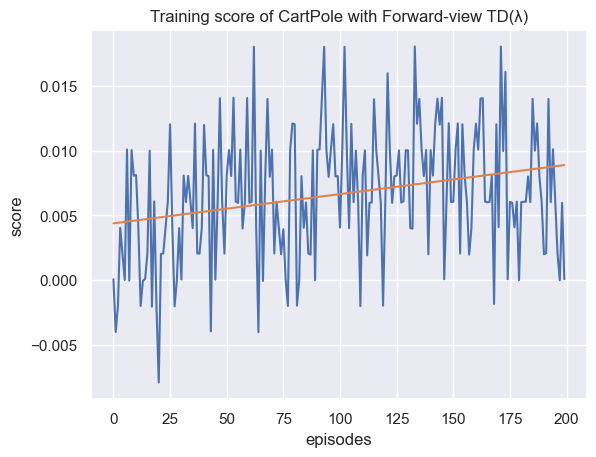

In [21]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(episode_rewards)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole with Forward-view TD(λ)')

reg = LinearRegression().fit(np.arange(len(episode_rewards)).reshape(-1, 1), np.array(episode_rewards).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(episode_rewards)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [24]:
done = False
# state = env.reset()[0]
scores = []

for test in tqdm(range(50)):
    state = env.get_state(reset=True)
    # state = torch.FloatTensor(state).unsqueeze(0)  # Shape adjustment for single sample
    done = False
    score = 0
    for step in range(600):
        #env.render()
        action_probs, state_value = actor_critic(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()

        ###############
        #####. deeply doubt the 2k action size!!!!
        ###############
        action_cluster_idx = action.item() // 2  # co trainig normally use 2 classifier,  fdin wich cluster todo
        action_clf_idx = action.item() % 2


        # Take the chosen action and observe the next state and reward
        next_state, reward, info = env.step(action_cluster_idx, action_clf_idx)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)

        # # Take the chosen action and observe the next state and reward
        # next_state, reward,info = env.step(action.item())

        # next_state = torch.FloatTensor(next_state).unsqueeze(0)
        score += reward
        state = next_state
    scores.append(score)

  0%|          | 0/50 [00:00<?, ?it/s]

0.007685046311331041
50


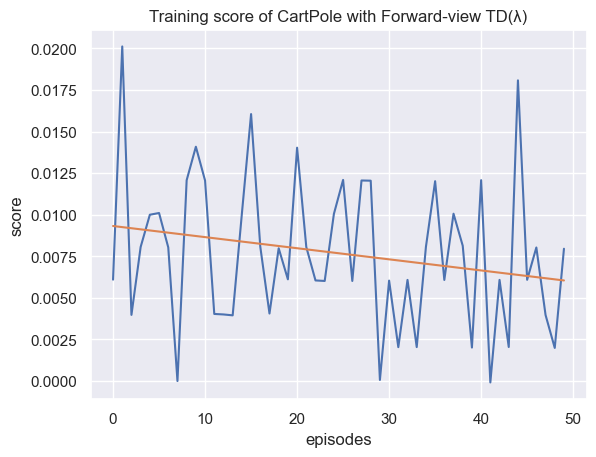

In [25]:
print(np.array(scores).mean())
print(len(scores))


sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole with Forward-view TD(λ)')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [19]:
env.observation_size

40

In [20]:
env.action_size

40